[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1aZ_vzIHshP81QXdqm_IAVjjJuNdAElsv#scrollTo=Y-Z9B6_QsPZw)

In [ ]:
#Subir credenciales de kaggle , en tu cuenta de kaggle ve a settings -> Create Token 
#Se descargara un archivo .json con tus credenciales
#Ese archivo es el que debes subir en este comando
from google.colab import files 
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"felipevasquezu","key":"eb7b2c1020732009b3b57f08a0eacbb3"}'}

In [ ]:
import pandas as pd
import numpy as np
import sys

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import plotly.express as px 
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from itertools import product
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer
import time
from multiprocessing import Pool

#**Descargar Datos desde Kaggle**

In [ ]:
!pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c store-sales-time-series-forecasting
! unzip store-sales-time-series-forecasting.zip
! rm store-sales-time-series-forecasting.zip
! rm kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 47% 10.0M/21.4M [00:00<00:00, 101MB/s]
100% 21.4M/21.4M [00:00<00:00, 143MB/s]
Archive:  store-sales-time-series-forecasting.zip
  inflating: holidays_events.csv     
  inflating: oil.csv                 
  inflating: sample_submission.csv   
  inflating: stores.csv              
  inflating: test.csv                
  inflating: train.csv               
  inflating: transactions.csv        


In [ ]:
path=''
# Load train
train_df = pd.read_csv(path+'train.csv', parse_dates=['date'], infer_datetime_format=True) # columna date a tipo fecha
# Load Test
test_df = pd.read_csv(path+'test.csv', parse_dates=['date'], infer_datetime_format=True) # columna date a tipo fecha
#Load stores
store_df = pd.read_csv(path+'stores.csv')
#Load oil 
oil_df = pd.read_csv(path+'oil.csv',parse_dates=['date'], infer_datetime_format=True)
#Load holidays
holiday_df= pd.read_csv(path+'holidays_events.csv', parse_dates=['date'], infer_datetime_format=True)
#Load transactions
transaction_df = pd.read_csv(path+'transactions.csv', parse_dates=['date'], infer_datetime_format=True)

# **FUNCIONES**

In [ ]:
def create_lags_by_column(df,num_lags,column):
  new_df =  pd.DataFrame(columns=df.columns)
  for y in range(1,55):
    current_df = df[df['store_nbr']== y ]
    for i in range(1,num_lags+1 ):
      current_df[f'lag_{column}_{i}'] = current_df[column].shift(i)

    current_df.dropna(inplace=True)
    current_df.reset_index(inplace=True)
    new_df = pd.concat([new_df, current_df], axis=0, ignore_index=True)
  return new_df

In [ ]:
def create_date_features(main_df):
  def get_date_features(df):
    df.loc[:,'day'] = df.date.dt.day
    df.loc[:,'month'] = df.date.dt.month.astype("int8")
    df.loc[:,'day_of_week'] = (df.date.dt.dayofweek + 1).astype("int8")
    df.loc[:,'year'] = df.date.dt.year.astype("int32")
    df.loc[:,"is_wknd"] = (df.date.dt.weekday // 4).astype("int8")
    df.loc[:,'week_of_month'] = (df.date.apply(lambda d: (d.day-1) // 7 + 1)).astype("int8")
    df.loc[:,'is_month_start'] = df.date.dt.is_month_start.astype("int8")
    df.loc[:,'is_month_end'] = df.date.dt.is_month_end.astype("int8")
    df.loc[:,'is_year_start'] = df.date.dt.is_year_start.astype("int8")
    df.loc[:,'is_year_end'] = df.date.dt.is_year_end.astype("int8")
    return df
  pd.options.mode.chained_assignment = None
  main_df = get_date_features(main_df)
  main_df.loc[:,"wageday"] = pd.Series(np.where((main_df['is_month_end'] == 1) | (main_df["day"] == 15), 1, 0)).astype("int8")
  return main_df

In [ ]:
def create_main_df2(df,oil,transaction,holiday,num_sales_lags,num_oil_lags,num_trans_lags):
  def create_holidays(df,holidays):
    #Creando Holidays 

    holiday = holidays[holidays['transferred'] == False].copy()
    holiday.rename(columns = {'type':'holiday_type'},inplace=True)
    holiday.drop(['transferred', 'description'], axis=1, inplace=True)

    #Festivos nacionales ( aplica a todas las tiendas)
    national_holidays = holiday[holiday['locale'] == 'National'][['date','holiday_type']].copy()
    national_holidays.rename(columns = {'holiday_type':'national_holiday_type'},inplace=True)
    national_holidays
    national_holidays.drop_duplicates(subset='date', keep="first", inplace=True)

    #Festivos de estados 
    state_holidays = holiday[holiday['locale'] == 'Regional'][['date','locale_name','holiday_type']].copy()
    state_holidays.rename(columns = {'locale_name':'state','holiday_type':'state_holiday_type'},inplace=True)
    state_holidays

    #Festivos por ciudad 
    city_holidays = holiday[holiday['locale'] == 'Local'][['date','locale_name','holiday_type']].copy()
    city_holidays.rename(columns = {'locale_name':'city','holiday_type':'city_holiday_type'},inplace=True)

    #Merge
    df = pd.merge(df, national_holidays, how='left', on=['date']) 
    df = pd.merge(df, state_holidays, how='left', on=['date','state']) 
    df = pd.merge(df, city_holidays, how='left', on=['date','city']) 

    #Convirtiendo columnas holidays a binarias 
    df.loc[df['national_holiday_type'].notna(), 'national_holiday_type'] = 1
    df.loc[df['national_holiday_type'].isna(), 'national_holiday_type'] = 0
    df['national_holiday_type'] =df['national_holiday_type'].astype(int)

    df.loc[df['state_holiday_type'].notna(), 'state_holiday_type'] = 1
    df.loc[df['state_holiday_type'].isna(), 'state_holiday_type'] = 0
    df['state_holiday_type'] =df['national_holiday_type'].astype(int)


    df.loc[df['city_holiday_type'].notna(), 'city_holiday_type'] = 1
    df.loc[df['city_holiday_type'].isna(), 'city_holiday_type'] = 0
    df['city_holiday_type'] =df['national_holiday_type'].astype(int)

    #Eliminado duplicados
    dup = df[['date','store_nbr']].duplicated()
    df.drop(index=df[dup].index,inplace=True)

    return df
  
  def create_oil(df,oil):
    oil_data = oil.copy()
    oil_data['dcoilwtico'] = oil_data['dcoilwtico'].fillna(oil_data['dcoilwtico'].rolling(3, min_periods=1).mean())
    oil_data = oil_data.rename(columns={'dcoilwtico': 'oil_price'})
    oil_data.loc[0,'oil_price']=oil_data.loc[1,'oil_price'] #setting first oil price
    df= pd.merge(df,oil_data,on='date',how='left')
    df['oil_price'].fillna(df['oil_price'].rolling(3, min_periods=1).mean(),inplace=True)
    return df

  df_main = df.copy()
  df_main.drop(['family'],axis=1,inplace=True)
  df_main = df_main.groupby(['date','store_nbr']).sum()[['sales','onpromotion']].reset_index()

  #Date features 
  create_date_features(df_main)

  #Transactions
  df_tran = transaction_df.groupby(['date','store_nbr']).sum().reset_index()
  df_main =  pd.merge(df_main,df_tran, on=['date','store_nbr'],how='left')
  df_main['transactions'].fillna(0,inplace=True)

  #Stores
  df_main = pd.merge(df_main,store_df, on='store_nbr',how='left')
  
  #Holidays
  df_main = create_holidays(df_main,holiday)

  #sorting DF 
  df_main = df_main.sort_values(['store_nbr','date'])

  #Merge Oil
  df_main = create_oil(df_main,oil)


  #Corregir los datos de la tienda 52
  sales_8=df_main[(df_main['store_nbr']==8) &(df_main['date']<'2017-04-20')].sales.values
  onpromo_50=df_main[(df_main['store_nbr']==50) & (df_main['date']<'2017-04-20')].onpromotion.values
  trans_34=df_main[(df_main['store_nbr']==34) & (df_main['date']<'2017-04-20')].transactions.values

  df_main['sales'].loc[(df_main['store_nbr']==52) & (df_main['date']<'2017-04-20')]=sales_8
  df_main['onpromotion'].loc[(df_main['store_nbr']==52) & (df_main['date']<'2017-04-20')]=onpromo_50
  df_main['transactions'].loc[(df_main['store_nbr']==52) & (df_main['date']<'2017-04-20')]=trans_34

  #Creating Lags 
  if num_sales_lags>0 :
    df_main = create_lags_by_column(df_main,num_sales_lags,'sales')
    df_main = df_main.drop(columns=['index'])
  
  if num_oil_lags>0 :
    df_main = create_lags_by_column(df_main,num_oil_lags,'oil_price')
    df_main = df_main.drop(columns=['index'])
    
  if num_trans_lags>0 :
    df_main = create_lags_by_column(df_main,num_trans_lags,'transactions')
    df_main = df_main.drop(columns=['index'])

  #Deleting unecesary columns
  df_main = df_main.drop(columns=['city','state','cluster','type'])

  return df_main

In [ ]:
def rmsle(y_true, y_pred):
  return  np.sqrt(mean_squared_log_error( y_true, y_pred ))

In [ ]:
def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, scoring='neg_mean_squared_log_error', train_sizes=np.linspace(0.1, 1.0, 12)
    )
    train_scores_mean = np.sqrt(-np.mean(train_scores,axis=1))
    test_scores_mean = np.sqrt(-np.mean(test_scores,axis=1))
    
    #plt.figure(figsize=(10 , 7.5))
   
    plt.plot(train_sizes, train_scores_mean, 'o-', label='Training error'  , color='r')
    plt.plot(train_sizes, test_scores_mean,  'o-', label='Validation error', color='g')
    plt.xlabel('Training Set Size')
    plt.ylabel('Root Mean Squared Logarithm Error')
    plt.title('Learning Curve')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# **MODELO**

## **Creacion de train y test**

In [ ]:
# Separar train data en datos de entrenamiento y test
train_data = train_df[train_df["date"]<="2017-03-01"]
test_data = train_df[train_df["date"]>"2017-03-01"]

In [ ]:
main_df_train = create_main_df2(train_data,oil_df,transaction_df,holiday_df,7,7,3)
main_df_test = create_main_df2(test_data,oil_df,transaction_df,holiday_df,7,7,3)

## **Búsqueda de los mejores hiperparametros para PCA y Random Forest para una tienda (Opcional)**

Busqueda de mejores hiperparametros para una sola tienda en especifico , aqui buscamos demostrar que los hiperparametros pueden cambiar dependiendo de la tienda que se escoja 

Nota : La Ejecucion de este bloque puede ser saltada ya que demora un tiempo , los mejores hiperparametros se encontraron y se usan en el siguiente bloque llamado (entrenamiento, prediccion y curva de aprendizaje para una sola tienda) 


In [ ]:
#Se escoge la tienda numero 22 

main_df_train_filtered = main_df_train[main_df_train['store_nbr']==22]
main_df_test_filtered = main_df_test[main_df_test['store_nbr']==22]

columns_serie = main_df_train_filtered.columns.values
columns_serie = np.delete(columns_serie,[0,2]) #Deleted date and sales 

Xtrain = main_df_train_filtered.loc[:,columns_serie].values
Ytrain = main_df_train_filtered.loc[:,'sales'].values

In [ ]:
# Crear y entrenar modelo
pca = PCA()
pca.fit(Xtrain)

PCA()

In [ ]:
#Determinar el numero óptimo de componentes 
cumsum_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumsum_variance >= 0.95) + 1

In [ ]:
#Entrenar el modelo con el número de componentes
pca = PCA(n_components=n_components)
pca.fit(Xtrain)

PCA(n_components=3)

In [ ]:
Xtrain_pca  = pca.transform(Xtrain)[:, :n_components]
Xtrain_pca.shape

(1500, 3)

In [ ]:
param_grid={
    'n_estimators':[100, 200, 300,],
    'max_depth':[6, 9, 12],
    'min_samples_split':[2,5,10],
    'min_samples_leaf':[1,2,4]
}

In [ ]:
grid_search = GridSearchCV(RandomForestRegressor(random_state=0), param_grid, cv=5, scoring=make_scorer(rmsle),n_jobs=-1)
grid_search.fit(Xtrain_pca,Ytrain)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [6, 9, 12], 'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring=make_scorer(rmsle))

In [ ]:
params=grid_search.best_params_
print(params)

{'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


## **Busqueda de los mejores hiperparametros para PCA y Random Forest para todas las tiendas (Opcional)**

Se busca encontrar los mejores  hiperaprametros para todo el dataset (las 54 tiendas incluidas)

Nota : La Ejecucion de este bloque puede ser saltada ya que mucho tiempo , los mejores hiperparametros se encontraron y se usan en el siguiente bloque llamado (entrenamiento, prediccion y curva de aprendizaje para todas las tiendas) 

In [ ]:
columns_serie = main_df_train.columns.values
columns_serie = np.delete(columns_serie,[0,2]) #Deleted date and sales 

Xtrain = main_df_train.loc[:,columns_serie].values
Ytrain = main_df_train.loc[:,'sales'].values

In [ ]:
# Crear y entrenar modelo
pca = PCA()
pca.fit(Xtrain)

PCA()

In [ ]:
#Determinar el numero optimo de componentes 
cumsum_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumsum_variance >= 0.95) + 1

In [ ]:
#Entrenar el modelo con el numero de componentes
pca = PCA(n_components=n_components)
pca.fit(Xtrain)

PCA(n_components=4)

In [ ]:
Xtrain_pca  = pca.transform(Xtrain)[:, :n_components]

In [ ]:
param_grid={
    'n_estimators':[100, 200, 300],
    'max_depth':[6, 9, 12]
}

In [ ]:
grid_search = GridSearchCV(RandomForestRegressor(random_state=0), param_grid, cv=5, scoring=make_scorer(rmsle),n_jobs=-1)
grid_search.fit(Xtrain_pca,Ytrain)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [6, 9, 12],
                         'n_estimators': [100, 200, 300]},
             scoring=make_scorer(rmsle))

In [ ]:
print(grid_search.best_params_)

{'max_depth': 6, 'n_estimators': 100}


In [ ]:
param_grid={
    'min_samples_split':[2,5,10],
    'min_samples_leaf':[1,2,4]
}
grid_search = GridSearchCV(RandomForestRegressor(n_estimators=100,max_depth=6), param_grid, cv=5, scoring=make_scorer(rmsle))
grid_search.fit(Xtrain_pca,Ytrain)
print(grid_search.best_params_)

{'min_samples_leaf': 1, 'min_samples_split': 2}


## **Entrenamiento , Prediccion y curva de aprendizaje para una sola tienda**

In [ ]:
#Validacion en caso de no haber ejecutado busqueda de hiperparametros
if 'grid_search' not in globals() or grid_search.best_params_ is None :
  params = {'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}

In [ ]:
t=6
main_df_train_filtered = main_df_train[main_df_train['store_nbr']==t]
main_df_test_filtered = main_df_test[main_df_test['store_nbr']==t]

columns_serie = main_df_train_filtered.columns.values
columns_serie = np.delete(columns_serie,[0,2]) #Deleted date and sales 

Xtrain = main_df_train_filtered.loc[:,columns_serie].values
Ytrain = main_df_train_filtered.loc[:,'sales'].values
Xtest = main_df_test_filtered.loc[:,columns_serie].values
Ytest = main_df_test_filtered.loc[:,'sales'].values

Xtrain_pca  = pca.transform(Xtrain)[:, :n_components]
Xtest_pca  = pca.transform(Xtest)[:, :n_components]

In [ ]:
#Crear nuevo modelo con los mejores hiperparametros
forecaster = RandomForestRegressor(n_estimators = params['n_estimators'] , max_depth = params['max_depth'], min_samples_split=params['min_samples_split'], min_samples_leaf=params['min_samples_leaf'] )
forecaster.fit(Xtrain_pca, Ytrain)

RandomForestRegressor(max_depth=12, n_estimators=200)

In [ ]:
#Prediccion y error
y_pred = forecaster.predict(Xtest_pca)
rmsle_test =(mean_squared_log_error(Ytest, y_pred ,squared=False))
print("RMSLE Test Random Forest Regressor : %.3f"%rmsle_test)

RMSLE Test Random Forest Regressor : 0.144


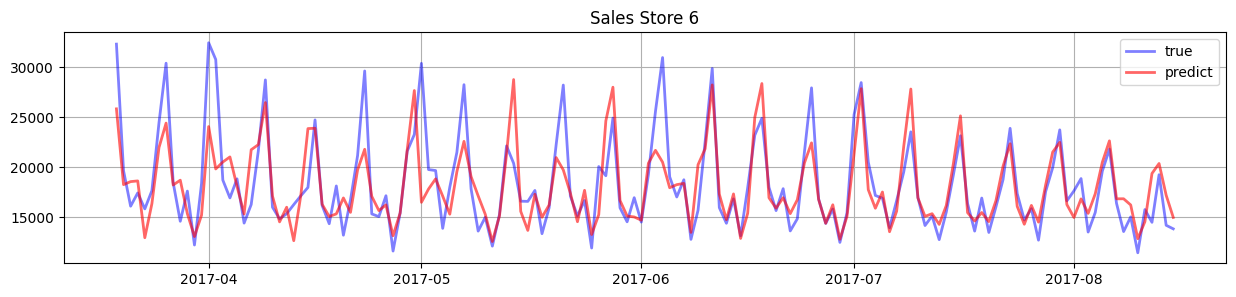

In [ ]:
#Grafica
plt.figure(figsize=(15,3))
plt.plot(main_df_test_filtered['date'], main_df_test_filtered['sales'], color="blue", lw=2, label="true", alpha=.5)
plt.plot(main_df_test_filtered['date'], y_pred, color="red", lw=2, label="predict", alpha=.6)
plt.title("Sales Store "+str(t))
plt.grid();
plt.legend();

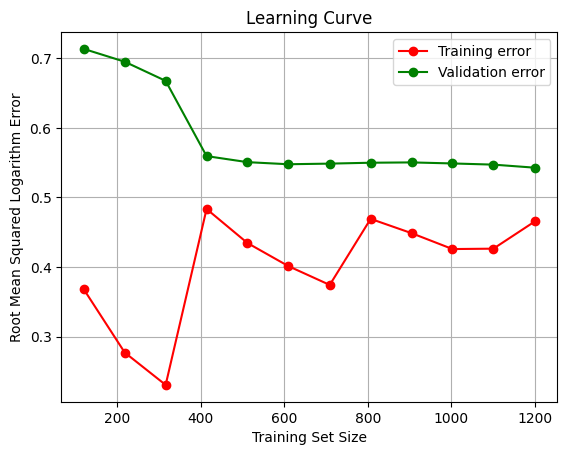

In [ ]:
plot_learning_curve(forecaster, Xtrain_pca, Ytrain)

## **Entrenamiento , Prediccion y curva de aprendizaje para todas las tiendas**

Para la predicción de todas las tiendas se usaran los mejores hiperparametros encontrados para todo el dataset en el modelo RandomForest  , por razones de facilidad de ejecución del notebook no se buscaran mejores hiperparametros para cada tienda ya que cada tienda tiene un modelo diferente y puede tardar 15 minutos para cada una de las 54 tiendas

In [ ]:
#Validacion en caso de no haber ejecutado busqueda de hiperparametros
if 'grid_search' not in globals() or grid_search.best_params_ is None :
  params = {'max_depth': 6 , 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

In [ ]:
#Funcion que crea los modelos PCA y Random Forest por cada tienda 
#Train,Test , Entrenamiento , prediccion y calculo de error 
def process_tienda(i):
  #Creando Xtrain,Ytrain,Xtest,Ytest
  train_filtered = main_df_train[main_df_train['store_nbr']==i]
  test_filtered = main_df_test[main_df_test['store_nbr']==i]

  columns_serie = train_filtered.columns.values
  columns_serie = np.delete(columns_serie,[0,2]) #Deleted date and sales 

  Xtrain = train_filtered.loc[:,columns_serie].values
  Ytrain = train_filtered.loc[:,'sales'].values
  Xtest = test_filtered.loc[:,columns_serie].values
  Ytest = test_filtered.loc[:,'sales'].values

  # Crear y entrenar modelo PCA
  pca = PCA()
  pca.fit(Xtrain)

  #Determinar el numero optimo de componentes 
  cumsum_variance = np.cumsum(pca.explained_variance_ratio_)
  n_components = np.argmax(cumsum_variance >= 0.95) + 1

  #Entrenar el modelo con el numero de componentes
  pca = PCA(n_components=n_components)
  pca.fit(Xtrain)

  Xtrain_pca  = pca.transform(Xtrain)[:, :n_components]
  Xtest_pca =pca.transform(Xtest)[:, :n_components]

  #Crear nuevo modelo con los mejores hiperparametros
  forecaster = RandomForestRegressor(n_estimators = params['n_estimators'], 
                                     max_depth = params['max_depth'],
                                     min_samples_split=params['min_samples_split'],
                                     min_samples_leaf=params['min_samples_leaf'] )
  forecaster.fit(Xtrain_pca, Ytrain)

  y_pred = forecaster.predict(Xtest_pca)
  rmsle_test =(mean_squared_log_error(Ytest, y_pred ,squared=False))
  print("\rRMSLE tienda %d : %.3f"% (i,rmsle_test))

  tienda = {
      'tienda_id':i,
      'y_pred': y_pred,
      'rmsle':rmsle_test,
      'xtrain_pca':Xtrain_pca
  }

  return tienda

In [ ]:
#Ejecuta la funcion de procesamiento de cada tienda en paralelo 
#Splint data , Entrenamiento , prediccion y calculo de error 
tiendas = np.empty(55, dtype=object)
def update_progress(result):
  tiendas[result['tienda_id']]=result

# Crea un pool de workers 
pool = Pool(processes=20) # numero de procesos en paralelo

# Ejecuta las tareas de forma asincrona 
for i in range(1, 55):
    pool.apply_async(process_tienda, args=(i,),callback=update_progress)

# Cierra el pool y espera a que todas las tareas terminen
pool.close()
pool.join()

RMSLE tienda 20 : 0.298
RMSLE tienda 8 : 0.118
RMSLE tienda 3 : 0.119
RMSLE tienda 17 : 0.158
RMSLE tienda 7 : 0.099
RMSLE tienda 18 : 0.188
RMSLE tienda 4 : 0.148
RMSLE tienda 16 : 0.272

RMSLE tienda 11 : 0.149
RMSLE tienda 5 : 0.107
RMSLE tienda 12 : 0.137


RMSLE tienda 6 : 0.125
RMSLE tienda 13 : 0.137
RMSLE tienda 19 : 0.122
RMSLE tienda 2 : 0.117
RMSLE tienda 14 : 0.197

RMSLE tienda 21 : 0.188
RMSLE tienda 22 : 0.194
RMSLE tienda 29 : 0.184
RMSLE tienda 42 : 0.190
RMSLE tienda 25 : 0.230
RMSLE tienda 24 : 0.167
RMSLE tienda 23 : 0.121
RMSLE tienda 36 : 0.151
RMSLE tienda 27 : 0.138
RMSLE tienda 28 : 0.218
RMSLE tienda 33 : 0.196
RMSLE tienda 40 : 0.189
RMSLE tienda 31 : 0.194

RMSLE tienda 34 : 0.104
RMSLE tienda 41 : 0.208
RMSLE tienda 32 : 0.441
RMSLE tienda 26 : 0.272
RMSLE tienda 37 : 0.131
RMSLE tienda 35 : 0.185
RMSLE tienda 38 : 0.175
RMSLE tienda 39 : 0.174
RMSLE tienda 43 : 0.194
RMSLE tienda 53 : 0.169
RMSLE tienda 44 : 0.151
RMSLE tienda 46 : 0.181
RMSLE tienda 47 : 

RSMLE max= 0.4409
RSMLE min= 0.0994
RSMLE promedio= 0.1779


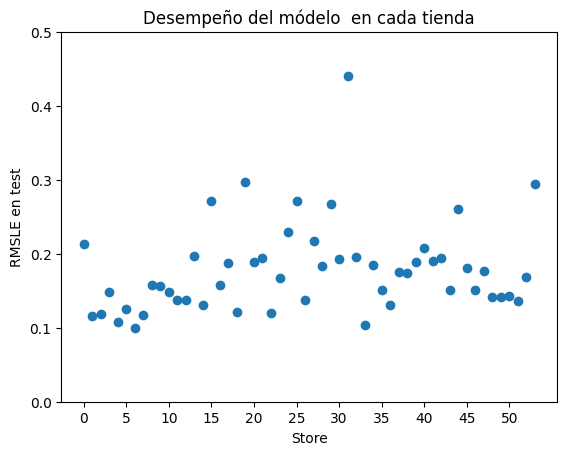

In [ ]:
#Grafica de los puntajes obtenidos en la prediccion de cada tienda
store_id=np.arange(1,55)
scores_tienda=np.zeros(55)
for i in store_id:
  scores_tienda[i]=tiendas[i]['rmsle']
scores_tienda=scores_tienda[1:]
plt.scatter(np.arange(len(scores_tienda)),scores_tienda)
plt.ylim([0, 0.5])
plt.xticks(np.arange(0,55,5))
plt.title('Desempeño del módelo  en cada tienda')
plt.xlabel("Store")
plt.ylabel("RMSLE en test")

print('RSMLE max=', "%.4f" % max(scores_tienda))
print('RSMLE min=', "%.4f" % min(scores_tienda))
print('RSMLE promedio=', "%.4f" % np.mean(scores_tienda))

In [ ]:
# Grafica Real vs Prediccion 
fig, axes = plt.subplots(18, 3, figsize = (20,50))
for i in range(1,55):
  #Calcular posicion de la grafica
  row, col = divmod(i - 1, 3)
  ax = axes[row, col]
  #filtrar tienda
  test_filtered = main_df_test[main_df_test['store_nbr']==i]
  #Grafica
  ax.plot(test_filtered['date'], test_filtered['sales'], color="blue", lw=2, label="true", alpha=.5)
  ax.plot(test_filtered['date'], tiendas[i]['y_pred'], color="red", lw=2, label="predict", alpha=.6)
  ax.set_title("store "+ str(i))
  ax.legend(loc='best')
  ax.grid()
  
plt.legend()
plt.tight_layout(pad=3)
plt.show()

### **Curva de aprendizaje**

Toma alrededor un total 8 minutos en mostrar la curva de aprendizaje de cada modelo entrenado para cada tienda , en total son 54 

In [ ]:
def process_learning_curve(i,forecaster):
  mensaje = ("Procesando tienda "+ str(i))
  print('\r'+mensaje)
  train_filtered = main_df_train[main_df_train['store_nbr']==i]

  #plot_learning_curve()
  train_sizes, train_scores, test_scores = learning_curve(
      forecaster, tiendas[i]['xtrain_pca'], train_filtered['sales'], cv=5, scoring='neg_mean_squared_log_error', train_sizes=np.linspace(0.1, 1.0, 10)
  )
  #promedio de los score para train y test
  train_scores_mean = np.sqrt(-np.mean(train_scores,axis=1))
  test_scores_mean = np.sqrt(-np.mean(test_scores,axis=1))
  score ={'tienda':i,
          'train':train_scores_mean,
          'test':test_scores_mean,
          'sizes':train_sizes}

  return score

In [ ]:
learning_scores=np.empty(55, dtype=object)
#declarar el modelo para la curva de aprendizaje
rf_learning_curve = RandomForestRegressor(n_estimators = params['n_estimators'], 
                                    max_depth = params['max_depth'],
                                    min_samples_split=params['min_samples_split'],
                                    min_samples_leaf=params['min_samples_leaf'] )
def update_progress_curve(score):
  learning_scores[score['tienda']]=score


# Crea un pool de workers 
pool2 = Pool(processes=20) # numero de procesos en paralelo
# Ejecuta las tareas de forma asincrona 
for i in range(1, 55):
    pool2.apply_async(process_learning_curve, args=(i,rf_learning_curve),callback=update_progress_curve)

# Cierra el pool y espera a que todas las tareas terminen
pool2.close()
pool2.join()


Procesando tienda 1
Procesando tienda 3
Procesando tienda 13
Procesando tienda 14
Procesando tienda 6






Procesando tienda 17








Procesando tienda 21
Procesando tienda 22
Procesando tienda 23
Procesando tienda 24
Procesando tienda 25
Procesando tienda 26
Procesando tienda 27

Procesando tienda 29
Procesando tienda 30
Procesando tienda 31
Procesando tienda 32
Procesando tienda 34

Procesando tienda 35
Procesando tienda 36
Procesando tienda 37
Procesando tienda 38
Procesando tienda 39
Procesando tienda 40
Procesando tienda 41
Procesando tienda 42
Procesando tienda 43
Procesando tienda 44
Procesando tienda 45
Procesando tienda 46
Procesando tienda 47
Procesando tienda 48
Procesando tienda 49
Procesando tienda 50
Procesando tienda 51
Procesando tienda 52
Procesando tienda 53
Procesando tienda 54


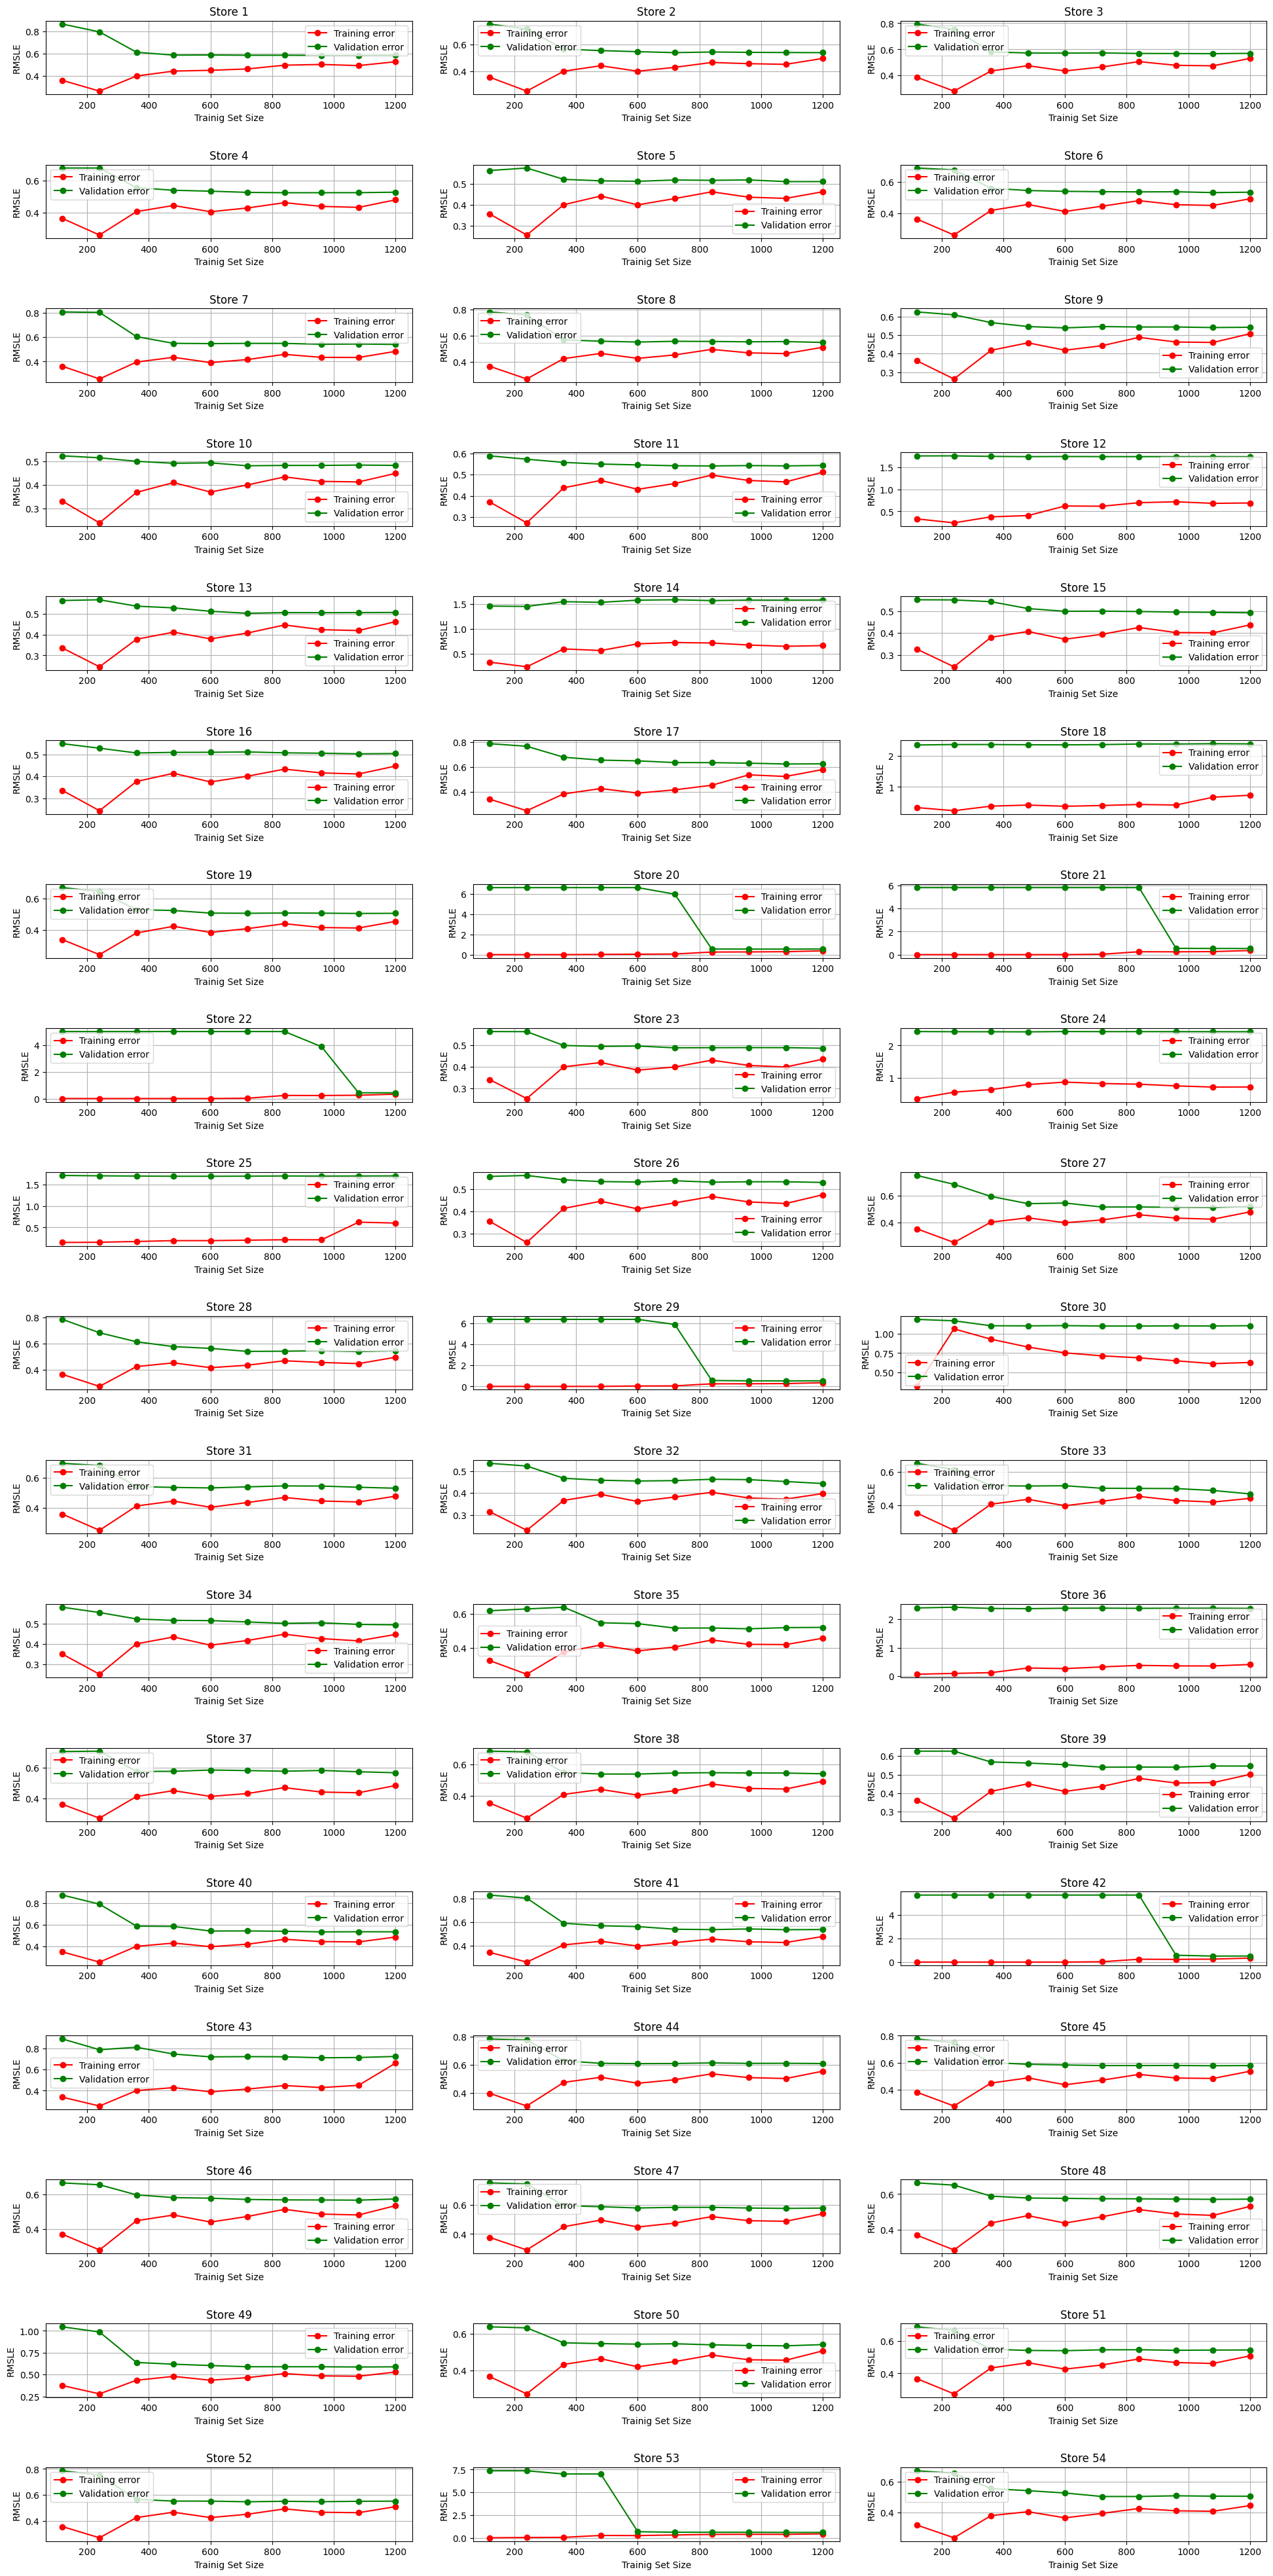

In [ ]:
fig, axes = plt.subplots(18, 3, figsize = (20,40)) 
for i in range(1,55):
  #Calcular posicion de la grafica
  row, col = divmod(i - 1, 3)
  ax = axes[row, col]

  #consultando scores
  tienda_score = learning_scores[i]
 
  ax.plot(tienda_score['sizes'], tienda_score['train'], 'o-', label='Training error'  , color='r')
  ax.plot(tienda_score['sizes'], tienda_score['test'],  'o-', label='Validation error', color='g')

 
  ax.set_title('Store ' + str(i))
  ax.legend(loc='best')
  ax.grid(True)

  for ax in axes.flat:
    ax.set(xlabel='Trainig Set Size', ylabel='RMSLE')

plt.tight_layout(pad=3)
plt.show()